In [1]:
!pip install xgboost



[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


XGBoost Accuracy: 0.8302
XGBoost Balanced Accuracy: 0.8303
Classification Report:
                 precision    recall  f1-score   support

         Europe       0.74      0.76      0.75        68
         France       0.87      0.88      0.88        68
        Germany       0.85      0.97      0.91        69
      Hong Kong       0.63      0.61      0.62        69
      Indonesia       0.84      0.91      0.88        69
          Japan       0.72      0.91      0.81        68
 Mainland China       0.66      0.48      0.55        69
       Malaysia       0.81      0.83      0.82        69
    Middle East       0.84      0.77      0.80        69
  North America       0.85      0.68      0.75        68
North East Asia       0.99      0.99      0.99        69
        Oceania       0.76      0.74      0.75        69
    Philippines       0.94      0.90      0.92        69
     South Asia       0.68      0.68      0.68        69
South East Asia       1.00      1.00      1.00        69
     

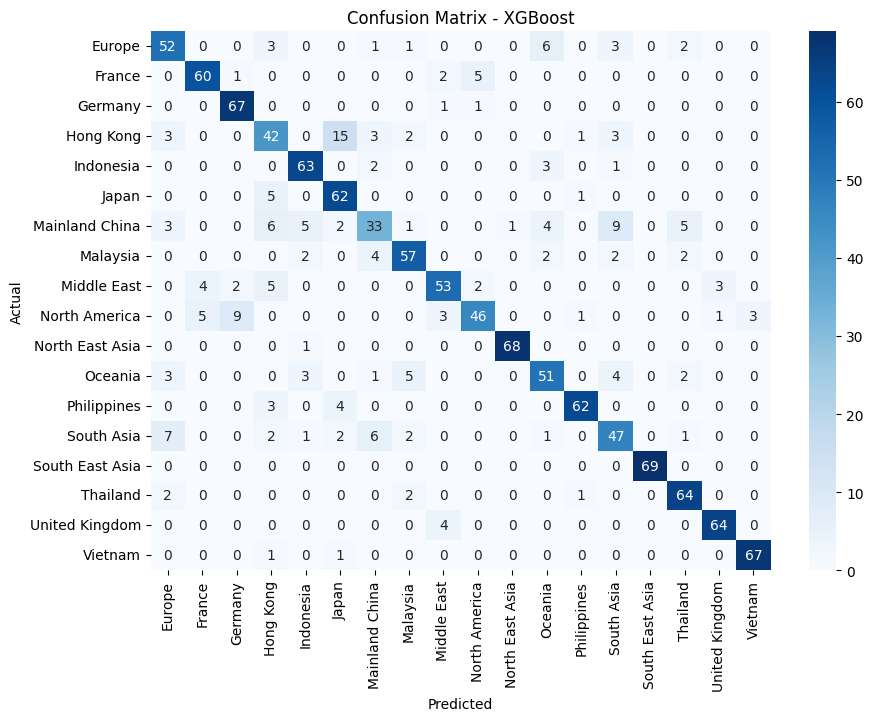

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("final_dataset_with_inflation_by_country.csv")

# Define features and target variable
X = df.drop(columns=['Country'])  # Feature set
y = df['Country']  # Target variable (Categorical)

# Encode categorical target variable to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert country names to numeric labels

# Split into train and test sets BEFORE SCALING
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data with the same scaler

# Train XGBoost Classifier
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = xgb.predict(X_test_scaled)

# Decode predictions back to original country names
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"XGBoost Balanced Accuracy: {balanced_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


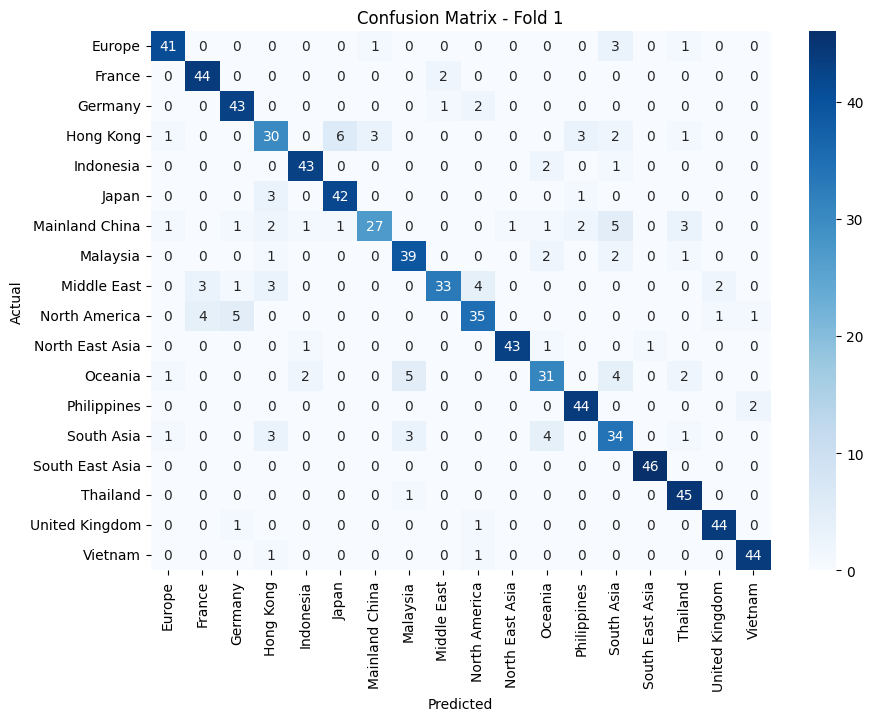

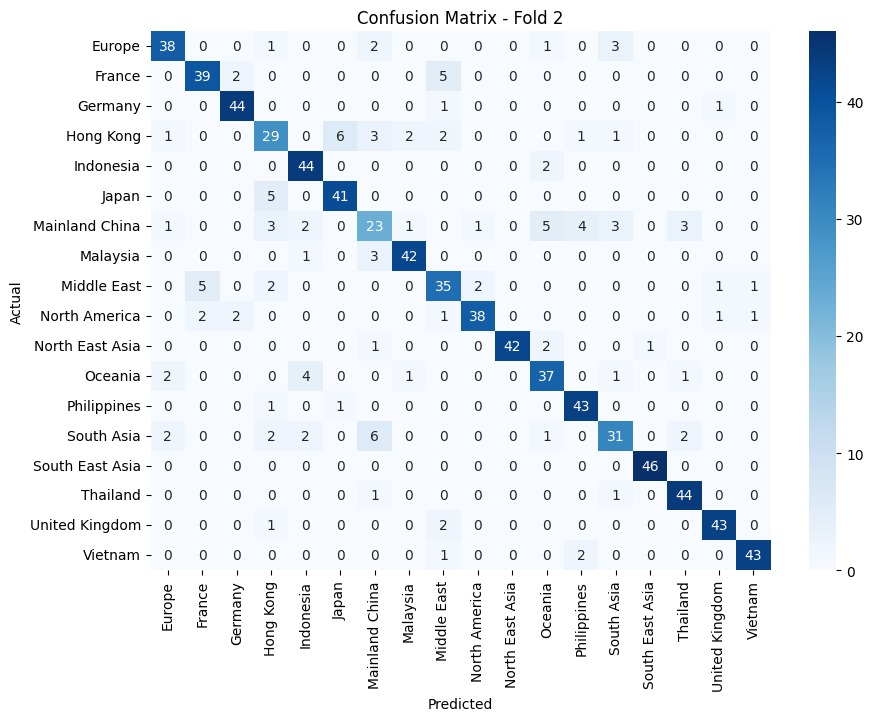

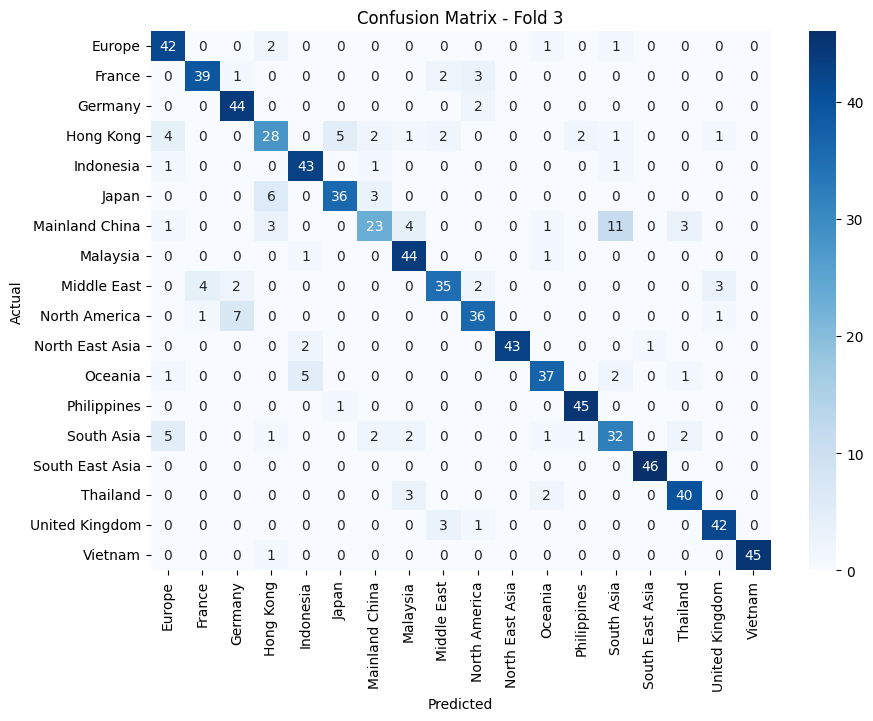

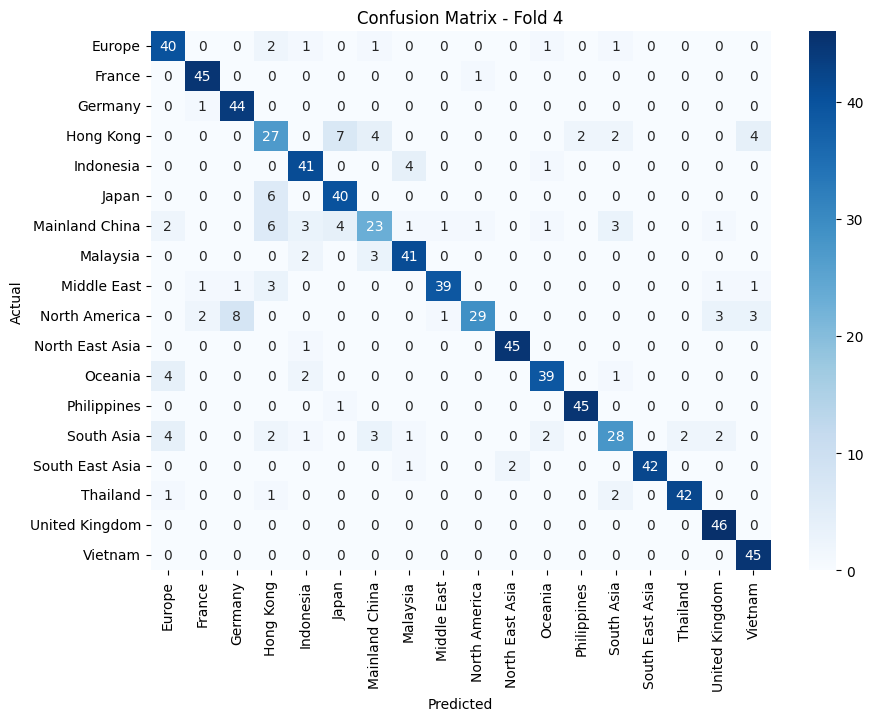

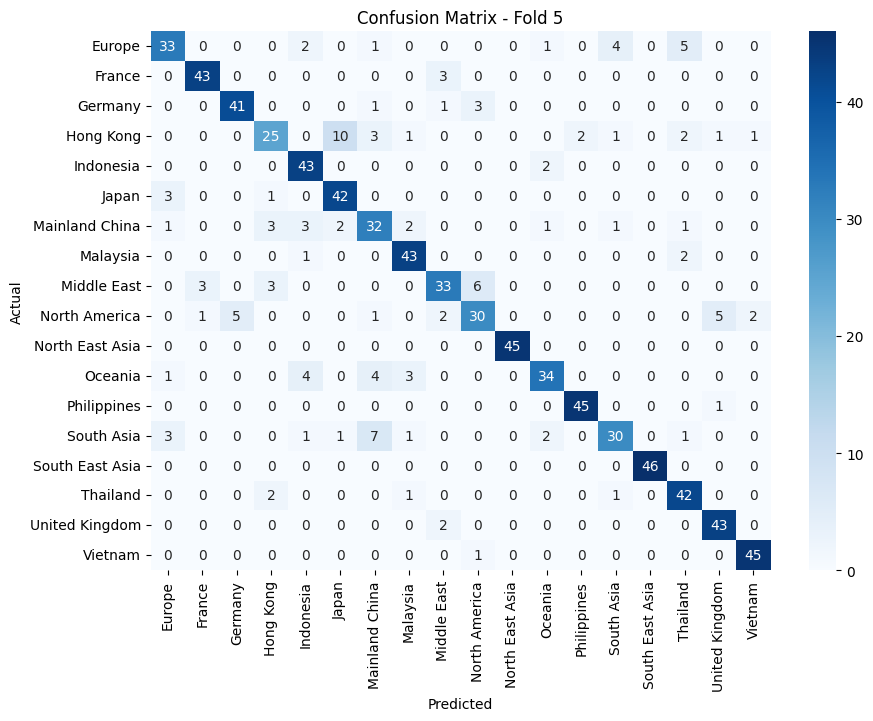

Mean Accuracy: 0.8508
Mean F1 Score: 0.8476
Mean Precision: 0.8504
Mean Recall: 0.8508


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Stratified K-Fold Cross-Validation (5 folds) - same as random forest
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store performance metrics
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []
conf_matrices = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X, y_encoded)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform training data
    X_val_scaled = scaler.transform(X_val)  # Transform validation data

    # Train XGBoost Classifier
    xgb = XGBClassifier(random_state=42)
    
    xgb.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = xgb.predict(X_val_scaled)

    # Store evaluation metrics
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    precision_list.append(precision_score(y_val, y_pred, average='weighted'))
    recall_list.append(recall_score(y_val, y_pred, average='weighted'))

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)
    
    # Plot confusion matrix for each fold
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

# Print average results
print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Mean F1 Score: {np.mean(f1_list):.4f}")
print(f"Mean Precision: {np.mean(precision_list):.4f}")
print(f"Mean Recall: {np.mean(recall_list):.4f}")

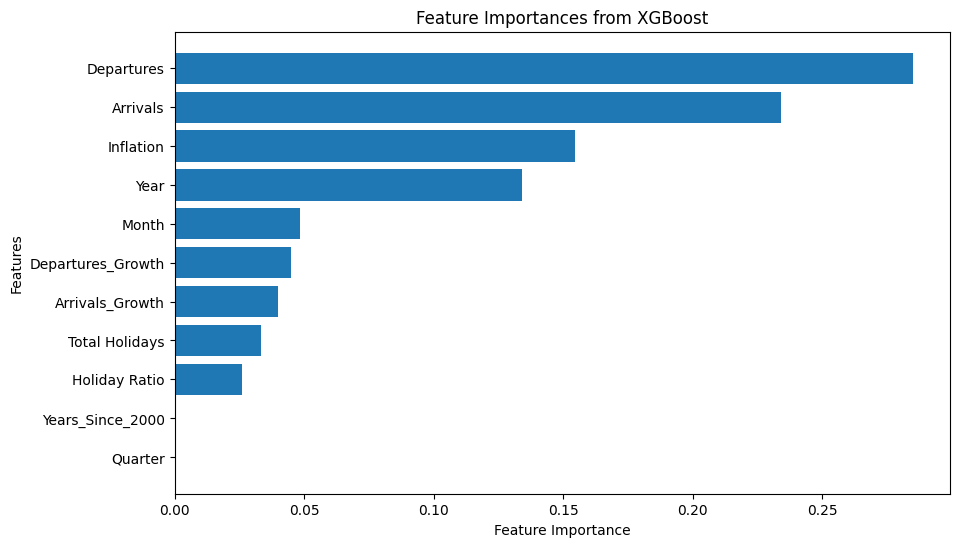

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is trained before accessing feature_importances_
feature_importances = xgb.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from XGBoost")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
# from lab
param_grid = {
    'max_depth': [2,3,4,5,6,7,8],
    'n_estimators': [100, 200, 300]
}

# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
xgb_grid.fit(X_train, y_train)

# Evaluate best model
y_pred = xgb_grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Accuracy: 0.9741
Balanced Accuracy: 0.9742
